In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

In [2]:
import warnings
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

In [3]:
 matches_df = pd.read_parquet("./esta/parsed/matches.parquet")
 rounds_df = pd.read_parquet("./esta/parsed/rounds.parquet")
 kills_df = pd.read_parquet("./esta/parsed/kills.parquet")
 damages_df = pd.read_parquet("./esta/parsed/damages.parquet") 
 grenades_df = pd.read_parquet("./esta/parsed/grenades.parquet") 
 bomb_events_df = pd.read_parquet("./esta/parsed/bomb_events.parquet") 
 weapon_fires_df = pd.read_parquet("./esta/parsed/weapon_fires.parquet") 
 flashes_df = pd.read_parquet("./esta/parsed/flashes.parquet") 
 frames_df = pd.read_parquet("./esta/parsed/frames.parquet")
 players_df = pd.read_parquet("./esta/parsed/players.parquet") 
 team_frames_df = pd.read_parquet("./esta/parsed/team_frames.parquet") 
 player_frames_df = pd.read_parquet("./esta/parsed/player_frames.parquet") 
 inventory_df = pd.read_parquet("./esta/parsed/inventory.parquet") 
 bomb_location_df = pd.read_parquet("./esta/parsed/bomb_location.parquet") 
 projectiles_df = pd.read_parquet("./esta/parsed/projectiles.parquet") 
 smokes_df = pd.read_parquet("./esta/parsed/smokes.parquet") 
 fires_df = pd.read_parquet("./esta/parsed/fires.parquet") 

image_dim = 1024

In [4]:
with open(".awpy/maps/map-data.json", "r") as f:
    map_data_all = json.load(f)

print(type(map_data_all))

<class 'dict'>


# Analyze Over 1 Specific Map

In [5]:
selected_map = 'de_mirage'

In [6]:
selected_matches = matches_df[matches_df.map_name == selected_map]
selected_matches.head()

,client_name,map_name,tick_rate,playback_ticks,playback_frames_count,parsed_to_frame_idx,match_id,demo_id,competition_name,hltv_url,match_date,match_name
0,GOTV Demo,de_mirage,127,343251,342767,342784,0839a031-0e2c-4c03-b4bc-b5ba05fe669a,01746483-b3bd-4e4b-a2f2-0de97b17600d,PGL Major Antwerp 2022,https://www.hltv.org/matches/2356160/heroic-vs...,1652781600000,heroic-vs-vitality-pgl-major-antwerp-2022
0,GOTV Demo,de_mirage,127,471790,471564,471581,0a075b4d-576e-46f2-b944-fe9542faee54,04f0fb8f-a4d7-497c-857e-316300fadee3,IEM Katowice 2022,https://www.hltv.org/matches/2354381/furia-vs-...,1645124400000,furia-vs-astralis-iem-katowice-2022
0,GOTV Demo,de_mirage,127,426251,425998,426016,a98ffca7-e968-4a54-9e8f-22f101c2502b,022866a3-090e-42eb-ab8e-aa553a575ada,IEM Katowice 2021,https://www.hltv.org/matches/2346573/faze-vs-f...,1613905200000,faze-vs-furia-iem-katowice-2021
0,GOTV Demo,de_mirage,127,441259,440692,440707,a56115fd-a0ba-4eea-a618-91fd6c57177c,015f7c8d-2bc0-4d83-88e7-60648d2b221c,BLAST Premier Fall Showdown 2021,https://www.hltv.org/matches/2351973/heroic-vs...,1634034600000,heroic-vs-poggerz-blast-premier-fall-showdown-...
0,GOTV Demo,de_mirage,127,493224,492014,492029,f218743d-5e8b-436e-91bd-b7b3664c56c3,0418eb19-853e-4b56-955c-d3eedf2b7e12,BLAST Premier Spring Final 2021,https://www.hltv.org/matches/2349173/natus-vin...,1623853200000,natus-vincere-vs-faze-blast-premier-spring-fin...


In [7]:
selected_match = selected_matches.iloc[0]

## Location of players over one round

In [8]:
idx_pf_df = player_frames_df.set_index(["match_id","round_num","frame_id"])

In [9]:
def transform_coord(map_data,player_loc):
    result = player_loc.copy()
        
    pos_x = map_data["pos_x"]
    pos_y = map_data["pos_y"]
    scale = map_data["scale"]

    result["x"] = (result["x"] - pos_x) / scale
    result["y"] = image_dim - (pos_y - result["y"]) / scale

    return result

In [ ]:
def transform_flash(flashes):
    

In [10]:
def plot_map(map_name,fig_size,fig=None,ax=None):
    fig,ax = plt.subplots(figsize=fig_size)
    map_img = plt.imread(f".awpy/maps/{map_name}.png")
    ax.imshow(map_img,extent=[0,image_dim,0,image_dim])
    ax.set_xlim(0, image_dim)
    ax.set_ylim(0, image_dim)
    ax.set_title(map_name.title())
    return fig,ax

In [11]:
def count_colorbar(fig):
    result = 0
    for ax in fig.axes:
        if "colorbar" in ax.get_label():
            result += 1
    return result

In [113]:
def plot_loc_unicode(player_loc, gradient_by, color_by,marker_symbols=None,fig=None, ax=None):
    if fig is None and ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))

    transformed = player_loc.reset_index()[["x", "y", gradient_by, color_by]]
    transformed[color_by] = transformed[color_by].str.lower()

    # Define Unicode marker symbols and colormaps.
    
    cmaps = ['Blues', 'Reds', 'Greys', 'Purples', 'Greens', 'Oranges']
    side = ['left', 'right']

    n_colorbar = count_colorbar(fig)
    for idx, color_category in enumerate(transformed[color_by].unique()):
        positions = transformed[transformed[color_by] == color_category]
        
        # Determine the marker symbol.
        if marker_symbols is not None and color_category in marker_symbols:
            marker_symbol = marker_symbols[color_category]

        colors = plt.get_cmap(cmaps[idx])(positions[gradient_by])
        
        for x, y, color in zip(positions['x'], positions['y'], colors):
            if marker_symbols is not None:
                ax.text(x, y, marker_symbol, fontsize=10, color=color, ha='center', va='center')
            else:
                ax.scatter(x,y,alpha=0.5,color=color,s=5)
                # ax.plot(x,y,"o",alpha=0.5,color=color,markersize=2)

        if idx < 2 and n_colorbar < 2:
            # Create a dummy scatter plot for the colorbar.
            dummy_scatter = ax.scatter(positions['x'], positions['y'], c=positions[gradient_by], cmap=cmaps[idx],s=0, alpha=.5)
            cbar = fig.colorbar(dummy_scatter, ax=ax, location=side[idx], pad=0.02,
                                    fraction=0.046, shrink=0.6)
            cbar.set_label(f"{color_category.upper()} {gradient_by.title()}", fontsize=8)
            cbar.ax.tick_params(labelsize=7)

    ax.set_xlabel("X Coordinate (pixels)")
    ax.set_ylabel("Y Coordinate (pixels)")
    return fig, ax



In [119]:
selected_round=10
idx_f_df = flashes_df.set_index(["match_id", "round_num", "tick"])

idx_f_df.loc[(selected_match.match_id, 10)].groupby('attacker_steam_id')\
.agg(players_flashed=('player_steam_id', 'count'))

,players_flashed
attacker_steam_id,
76561197983956651,1
76561197989744167,2
76561197996678278,1
76561198004115516,9
76561198004854956,6
76561198064864198,3
76561198113666193,3
76561198160709585,4


In [120]:
idx_f_df.columns

Index(['seconds', 'clock_time', 'attacker_steam_id', 'attacker_name',
       'attacker_team', 'attacker_side', 'attacker_x', 'attacker_y',
       'attacker_z', 'attacker_view_x', 'attacker_view_y', 'player_steam_id',
       'player_name', 'player_team', 'player_side', 'player_x', 'player_y',
       'player_z', 'player_view_x', 'player_view_y', 'flash_duration'],
      dtype='object')

In [115]:
flash_selected_round = idx_f_df.loc[(selected_match.match_id,selected_round)].reset_index()
flash_selected_round.columns

Index(['tick', 'seconds', 'clock_time', 'attacker_steam_id', 'attacker_name',
       'attacker_team', 'attacker_side', 'attacker_x', 'attacker_y',
       'attacker_z', 'attacker_view_x', 'attacker_view_y', 'player_steam_id',
       'player_name', 'player_team', 'player_side', 'player_x', 'player_y',
       'player_z', 'player_view_x', 'player_view_y', 'flash_duration'],
      dtype='object')

In [121]:
flashers = flash_selected_round[["attacker_x","attacker_y","tick"]]
flashers["type"] = "flasher"
flashers.columns = ["x","y","tick","type"]

flasheds = flash_selected_round[["player_x","player_y","tick"]]
flasheds["type"] = "flashed"
flasheds.columns = ["x","y","tick","type"]

round_flashes = pd.concat([flashers,flasheds])
round_flashes["tick"] = round_flashes["tick"] - round_flashes["tick"].min()

/tmp/nix-shell.8n2WBQ/ipykernel_37921/1635933525.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flashers["type"] = "flasher"
/tmp/nix-shell.8n2WBQ/ipykernel_37921/1635933525.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flasheds["type"] = "flashed"


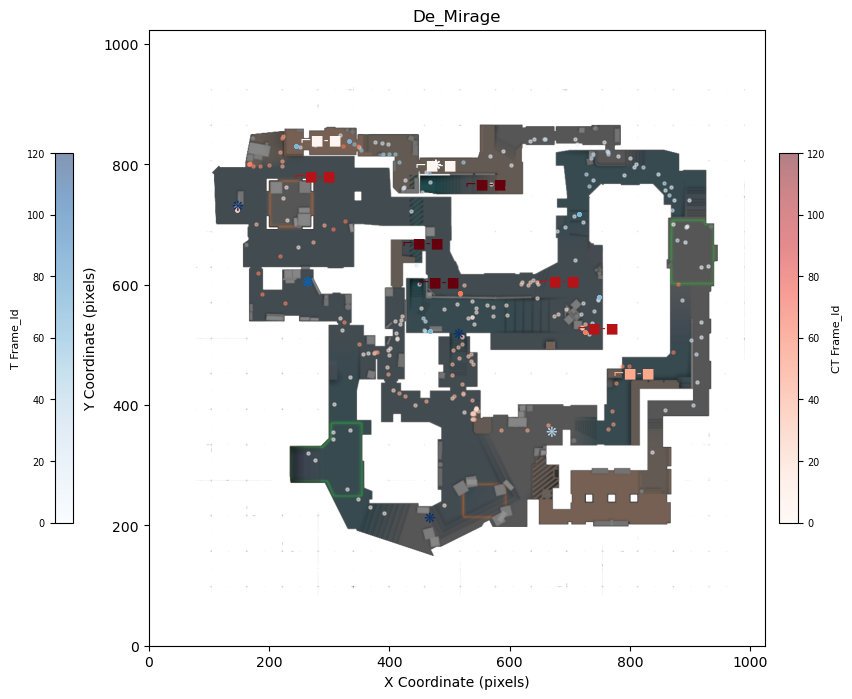

In [122]:
flash_symbol = {
    "flasher" : "$\u274B$",
    "flashed" : "⌐■-■",
}

transformed = transform_coord(map_data_all[selected_map],idx_pf_df.loc[(selected_match.match_id,selected_round)])\
.iloc[::3]
img_fig,img_ax = plot_map(selected_map,(10,8))
loc_fig,loc_ax = plot_loc_unicode(transformed,"frame_id","side",None,img_fig,img_ax)
transformed_flash = transform_coord(map_data_all[selected_map],round_flashes)
flash_fig,flash_ax = plot_loc_unicode(transformed_flash,"tick","type",flash_symbol,loc_fig,loc_ax)
plt.show()